# Seismic Geometry tutorial

One of the crucial parts of our framework is a class `SeismicGeometry` that holds information about underlying cube of amplitudes in **SEG-Y** or **HDF5** format. It can work with auxilliary headers, allowing the user to infer info and load data for the seismic volumes on various stages of processing. The main capabilities of `SeismicGeometry` are:

- infer information about traces in the cube, based on one or mode headers
- collect spatial and integral statistics about amplitude values
- provide methods for loading actual data for a desired 3D location
- convert cubes in a **SEG-Y** format to a much faster **HDF5**, when it is possible

Note that the only time when we load more that one trace into memory is when we specifically ask for it: all the information collection is done in a sequential way, without ever requiring too much of RAM.

This notebook demonstrates how to use the class for various types of cubes, as well as shows a number of methods and properties, that help us to examine the geology.

In [1]:
%load_ext autoreload
%autoreload 2

# All the necessary imports
import sys
import numpy as np

sys.path.append('..')
from seismiqb import SeismicGeometry, plot_image

# Pre-stack cube: FieldRecord/TraceNumber headers

First of all, we will load a regular pre-stack cube. Besides cube locaion on the disk, we need to specify:

- headers that are stored for each trace
- which of the headers are used as unique identifier: in our case, it is `FieldRecord` and `TraceNumber`
- whether we want to collect amplitude statistics and spatial stats

In [2]:
%%time
geometry = SeismicGeometry(
    '/data/seismic/CUBE_PRE/DN02B_SHOTS_LIFT1.sgy',
    headers=['FieldRecord', 'TraceNumber', 'offset'],
    index_headers=['FieldRecord', 'TraceNumber'],
    collect_stats=True, spatial=False,
)

print(geometry)



Geometry for cube              /data/seismic/CUBE_PRE/DN02B_SHOTS_LIFT1.sgy
Current index:                 ['FieldRecord', 'TraceNumber']
Shape:                         [  51 3456 3001]
Time delay and sample rate:    0, 2.0

Cube size:                     2.01 GB
Size of the instance:          0.338 GB

Number of traces:              176256

Num of unique amplitudes:      30373793
Mean/std of amplitudes:        -2.14583e-06/0.288117
Min/max amplitudes:            -26.6664/26.9622
q01/q99 amplitudes:            -0.878375/0.879571

CPU times: user 14.7 s, sys: 2.39 s, total: 17.1 s
Wall time: 15.9 s


As we can see, representation of `geometry` instance gives us information about its dimensionality, as well as describes collected amplitude stats. Note the relation of the size of the instance to the size of the cube: in the case of small cubes such as this one, the `SeismicGeometry` collects amount of information, comparable to the cube volume.

This time, we hardcoded headers and indexing headers: for conveniency, some of the most useful combinations are already stored in the `SeismicGeometry` class as attributes:

In [3]:
print(SeismicGeometry.HEADERS_PRE_FULL)
print(SeismicGeometry.INDEX_PRE)

['FieldRecord', 'TraceNumber', 'TRACE_SEQUENCE_FILE', 'CDP', 'CDP_TRACE', 'offset']
['FieldRecord', 'TraceNumber']


The required headers for each trace are stored in a a regular `pandas` dataframe:

In [4]:
geometry.dataframe

trace_index  offset
FieldRecord TraceNumber                     
111906      1656                   0      35
            1657                   1      36
            1655                   2      78
            1658                   3      79
            1654                   4     127
...                              ...     ...
111959      3                 175957    4949
            2                 175958    4983
            143               175959    4983
            144               175960    5018
            1                 175961    5019

[175962 rows x 2 columns]

One of the main usages of `SeismicGeometry` is to load slices of amplitudes. To do so, we use `load_slide` method, that takes a number of slice that we want to load. The loading acts along the specified axis (0 by default), which corresponds to a `FieldRecord` in our case. 

In [5]:
%%time
slide = geometry.load_slide(loc=30)

CPU times: user 339 ms, sys: 55.8 ms, total: 395 ms
Wall time: 393 ms


All of the actual data loading is heavily cached: so, if we load the same slice the second time, it is performed almost instantaneously:

In [6]:
%%time
slide = geometry.load_slide(loc=30)

CPU times: user 24 µs, sys: 13 µs, total: 37 µs
Wall time: 42.4 µs


That behaviour is extremely useful when loading thousands of slices, for example, in the process of neural network training. Note that the size of speedup, achieved by caching, vary depending on exact sampling procedure: if we are using very few slices of data, which would be always in cache, the load would be always very fast; on the other hand, if we are to generate uniformly random slices from the entire cube, the effect would not be that noticable.

We provide `plot_image` function to visualize data: it main purpose is to parse all the arguments and use them at appropriate places of `matplotlib`:

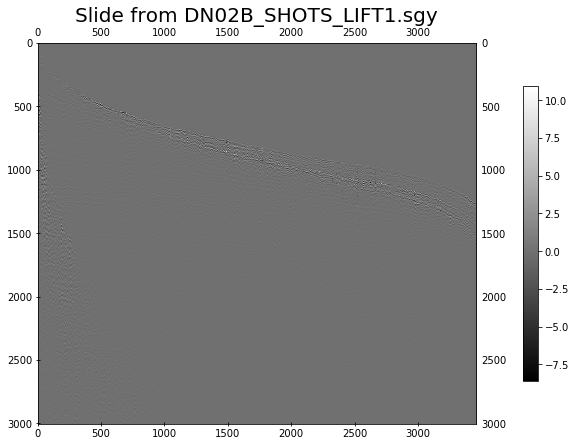

In [7]:
plot_image(slide, title=f'Slide from {geometry.name}', cmap='gray')

Although, we also provide `show_slide` method of `SeismicGeometry` class, that adds some nice defaults like labels and titles:

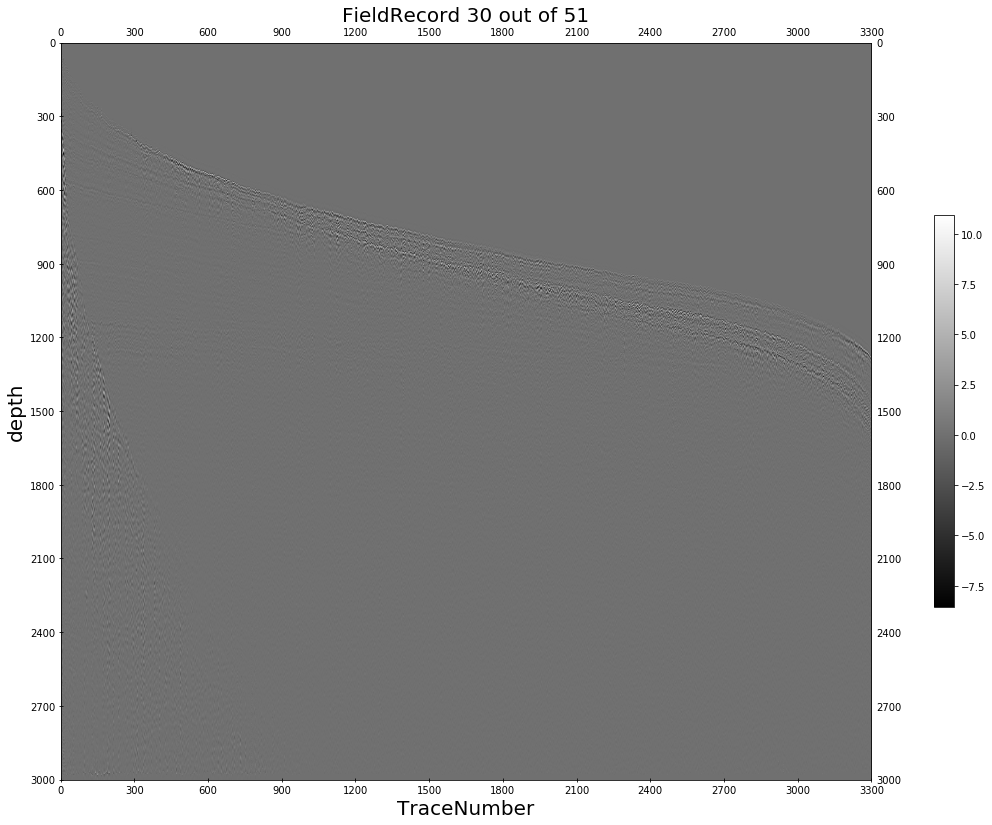

In [8]:
geometry.show_slide(loc=30, figsize=(16, 24))

As has already been notices, the size of the instance is quite large. Most of that size is occupied by `trace_container` attribute, which stores a lot of traces from the cube inside, that are raveled into one extremely long array. That storage is really handy when it comes to exploration of the actual amplitude values: it is big enough to accurately show the amplitude-distribution, so it can be used to derive all kinds of conclusions about it. A number of instance attributes are computed from this array, like `q01` (1% quantile of the amplitudes in the cube) and `q99` (the 99% quantile). Method `show_amplitude_hist` does exactly what the name says.

***`keep_num` argument of the initialization allows to control the number of stored traces.***

Size of the trace container: 0.3353 GB
Number of stored traces: 14997
1% and 99% quantiles of the amplitudes: -0.8783748865127563, 0.8795711755752555


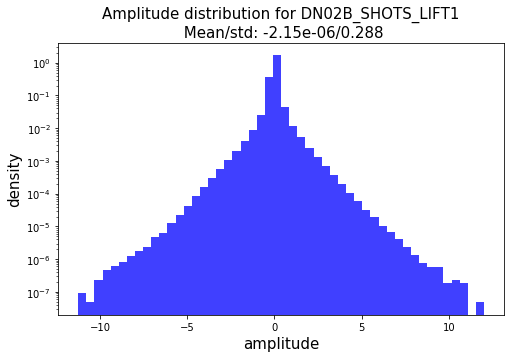

In [9]:
tc = geometry.trace_container
print(f'Size of the trace container: {tc.nbytes / (1024 ** 3):4.4} GB')
print(f'Number of stored traces: {len(tc) // geometry.depth}')
print(f'1% and 99% quantiles of the amplitudes: {geometry.q01}, {geometry.q99}')

geometry.show_amplitude_hist(log=True)

# 2D seismic: TraceNumber header

In [10]:
%%time
geometry = SeismicGeometry(
    '/data/seismic/CUBE_D2/Line_2786008_LMK.segy',
    headers=SeismicGeometry.HEADERS_PRE_FULL,
    index_headers = ['TraceNumber'],
    collect_stats=True, num_keep=30, spatial=False, 
)

print(geometry)



Geometry for cube              /data/seismic/CUBE_D2/Line_2786008_LMK.segy
Current index:                 ['TraceNumber']
Shape:                         [ 611 1989]
Time delay and sample rate:    -10, 2.0

Cube size:                     0.00467 GB
Size of the instance:          0.000495 GB

Number of traces:              611

Num of unique amplitudes:      183
Mean/std of amplitudes:        -0.0041321/14.5848
Min/max amplitudes:            -122.0/ 113.0
q01/q99 amplitudes:             -41.0/  39.0

CPU times: user 61.7 ms, sys: 2.57 ms, total: 64.2 ms
Wall time: 55.6 ms


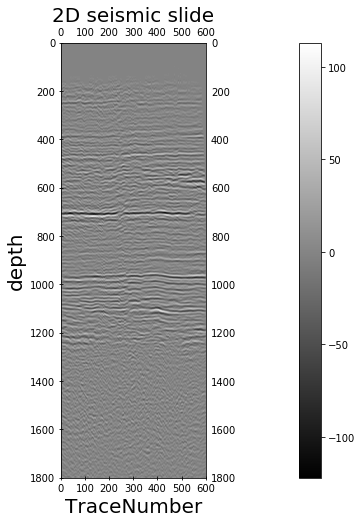

In [11]:
geometry.show_slide(figsize=(24, 8))

# Post-stack: cdp_x/cdp_y headers

Most of post-stack cubes still provide `cdp_x` and `cdp_y` headers for the traces. We can use them for cube loading:

In [12]:
%%time
geometry = SeismicGeometry(
    '/data/seismic/CUBE_1/E_anon.sgy',
    headers=SeismicGeometry.HEADERS_POST_FULL,
    index_headers=SeismicGeometry.INDEX_CDP,
)

print(geometry)


Geometry for cube              /data/seismic/CUBE_1/E_anon.sgy
Current index:                 ['CDP_Y', 'CDP_X']
Shape:                         [2563 1409 1501]
Time delay and sample rate:    50, 2.0

Cube size:                     21.0 GB
Size of the instance:          0.0673 GB

Number of traces:              3611267

CPU times: user 864 ms, sys: 1.02 s, total: 1.89 s
Wall time: 1.88 s


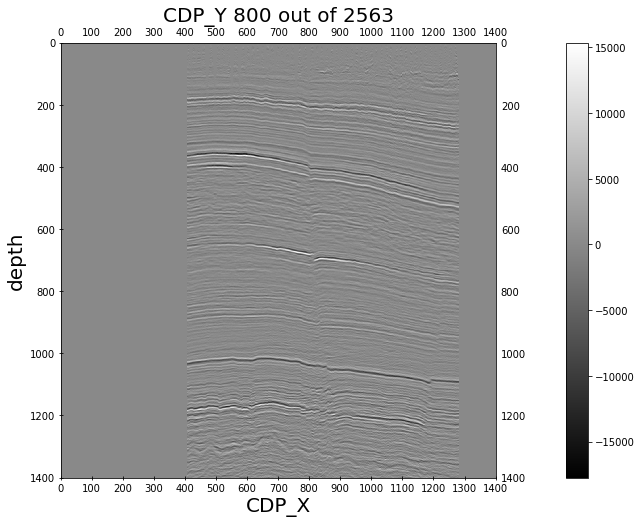

In [13]:
geometry.show_slide(loc=800, figsize=(18, 8))

Note that `inline`/`crossline` index is much preffered: those headers are represented by integer values, and their usage as index is much more robust. A common flaw of such an index is that multiple `cdp_x` can correspond to one `crossline`: a set of `10.25`, `10.2501` values can be labeled as the first crossline, which makes the unique indexing much harder to impose. 

All in all, if the `inline`/`crossline` headers are provided, always use them instead of the much more flawed `cdp_x`/`cdp_y` pair.

# Post-stack: inline/crossline headers

This is a cube after multiple steps of processing: it is already summed and each trace has a dedicated `inline` and `crossline`. That defines a clear spatial structure, so we can also collect `spatial` stats for this cube:

In [14]:
%%time
geometry = SeismicGeometry(
    '/data/seismic/CUBE_2/M_cube.sgy',
    headers=SeismicGeometry.HEADERS_POST_FULL,
    index_headers=SeismicGeometry.INDEX_POST,
    collect_stats=True, spatial=True,
)

print(geometry)



Geometry for cube              /data/seismic/CUBE_2/M_cube.sgy
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Shape:                         [ 418  869 2001]
Time delay and sample rate:    0, 2.0

Cube size:                     2.79 GB
Size of the instance:          0.304 GB

Number of traces:              363242
Number of non-zero traces:     352729

Num of unique amplitudes:      238
Mean/std of amplitudes:        -1.25654/4093.19
Min/max amplitudes:            -45939.2/71205.8
q01/q99 amplitudes:            -12403.6/10566.0

CPU times: user 53.4 s, sys: 1.29 s, total: 54.7 s
Wall time: 54.3 s


Collecting `spatial` stats takes some time, and creates a number of additional attributes:

- `min_matrix`, `max_matrix`, `mean_matrix`, `std_matrix` store minimum, maximum, average and variance values for each of the cube traces
- `hist_matrix` stores a whole histogram of values for each trace: all of them are created with the same bins, so the distributions are directly comparable

Each `*_matrix` has the same dimensionality, as the spatial range of the cube: we can see that the cube has 418 inlines and 869 crosslines, and each matrix has the same shape. Most of the cubes are padded with zero traces on the edges to have a rectangular shape; as there is no valuable stats for such traces, we fill their locations with NaNs inside every matrix, which corresponds to white filling color on images:

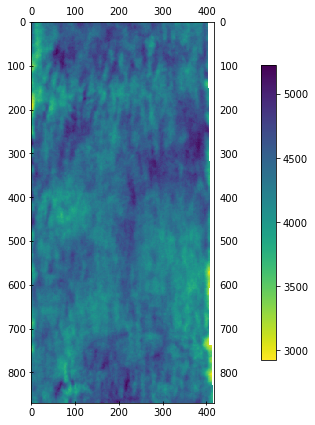

In [15]:
plot_image(geometry.std_matrix)

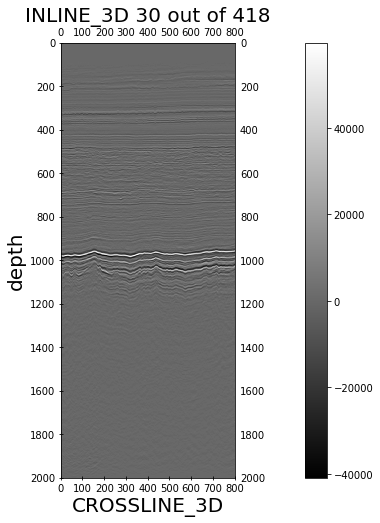

In [16]:
geometry.show_slide(loc=30, figsize=(18, 8))

As the bottom of the slide is very noise and does not provide much insight, we would like to zoom in, for example, at heights from 750 to 1250. `zoom_slice` parameter does exactly that:

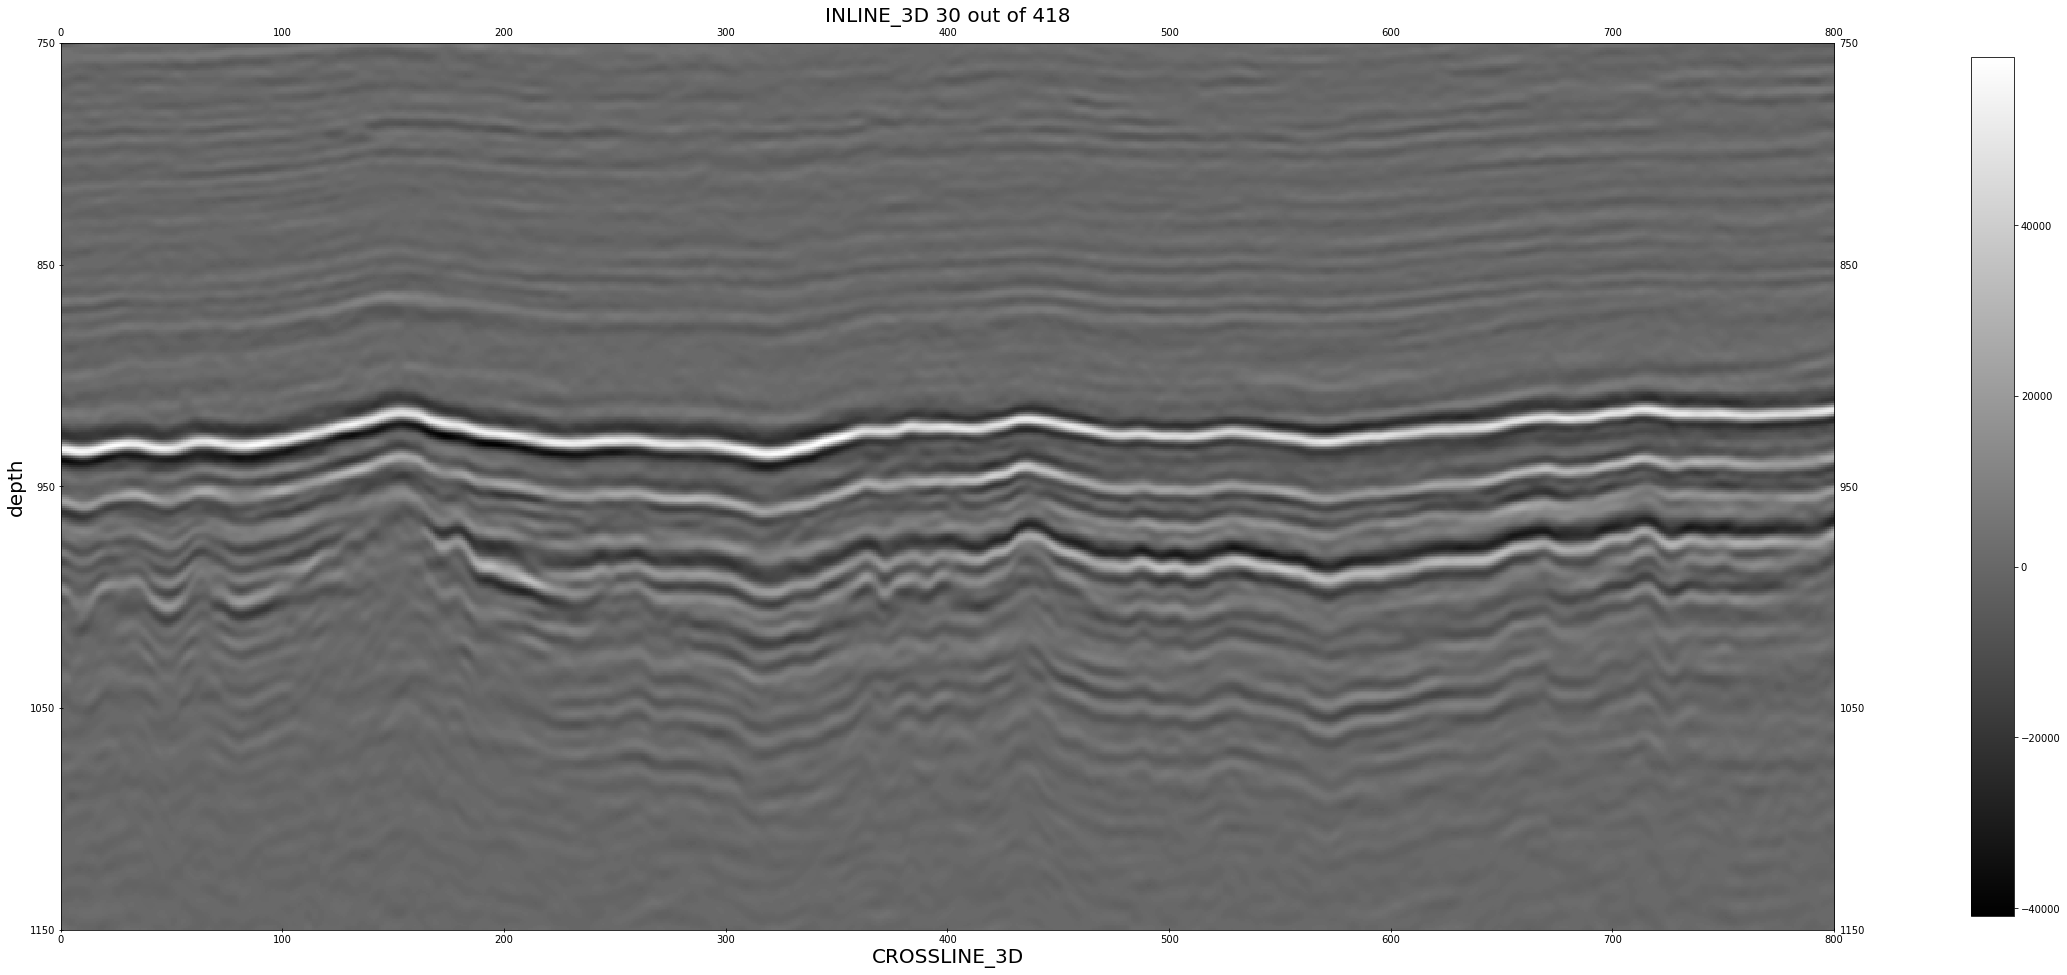

In [17]:
geometry.show_slide(loc=30, figsize=(35, 35),
                    zoom_slice=(slice(None), slice(750, 1250)))

Sometimes, change of colormap helps to distinguish reflections such as horizons and faults:

***We also zero-center the image by passing `zmin` and `zmax` values.***

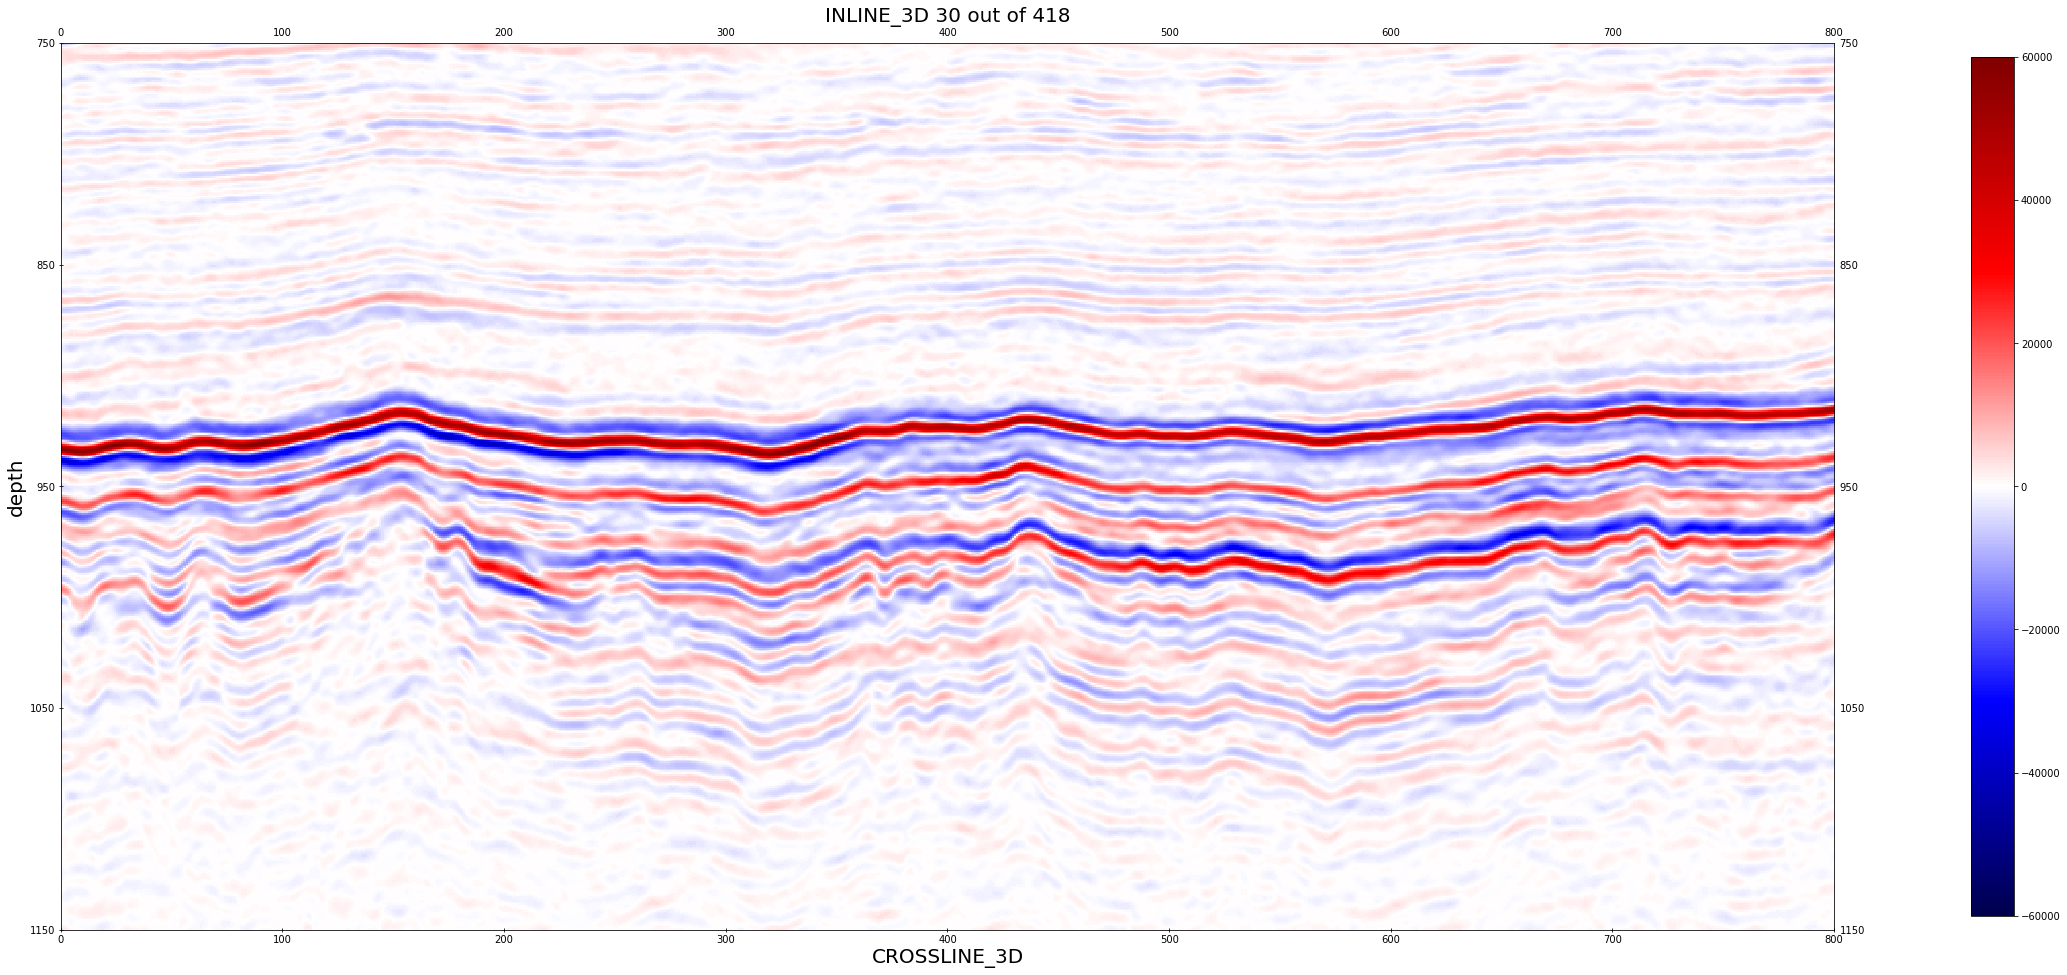

In [18]:
geometry.show_slide(loc=30, figsize=(35, 35),
                    zoom_slice=(slice(None), slice(750, 1250)),
                    cmap='seismic', zmin=-60000, zmax=60000)

As has been already mentioned, we can load and show slices along various axis:

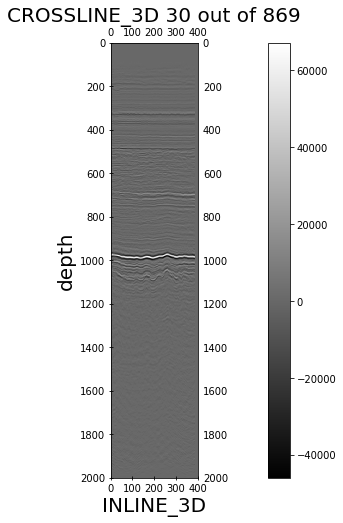

In [19]:
geometry.show_slide(loc=30, axis=1, figsize=(18, 8))

Lets check the timing of slide loading: we will compare with a more effecient storage later.

In [20]:
%time slide = geometry.load_slide(111)
%time slide = geometry.load_slide(111)

CPU times: user 23.1 ms, sys: 11.9 ms, total: 35 ms
Wall time: 26.9 ms
CPU times: user 29 µs, sys: 6 µs, total: 35 µs
Wall time: 40.5 µs


In [21]:
%time slide = geometry.load_slide(111, axis=1)
%time slide = geometry.load_slide(111, axis=1)

CPU times: user 22.6 ms, sys: 500 µs, total: 23.1 ms
Wall time: 22.2 ms
CPU times: user 36 µs, sys: 7 µs, total: 43 µs
Wall time: 50.3 µs


**SEG-Y** format is, essentially, 2D container of traces. That is not very effecient for the purposes of slide loading, and we can reshape this array into actual 3D cube of values. We store it in **HDF5** format, as well as all the collected stats, so the converted file does not need to infer them each time during the initialization.

***By default, `.hdf5` cube is stored right next to its `sgy` counterpart.***

***Creating a 3D volume requires a strict and clear spatial structure, so its usage is restricted to `iline`/`crossline` indexing headers.***

In [22]:
%%time
geometry.make_hdf5()


CPU times: user 25 s, sys: 24.2 s, total: 49.3 s
Wall time: 49.1 s


# Post-stack: inline/crossline headers, HDF5

After converting the cube, we re-create the instance: this time, we don't need to add any other parameters, as they are already stored in the file itself.

In [23]:
geometry = SeismicGeometry('/data/seismic/CUBE_2/M_cube.hdf5')

print(geometry)


Geometry for cube              /data/seismic/CUBE_2/M_cube.hdf5
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Shape:                         [ 418  869 2001]
Time delay and sample rate:    0, 2.0

Cube size:                     8.42 GB
Size of the instance:          0.297 GB

Number of traces:              363242
Number of non-zero traces:     352729

Num of unique amplitudes:      238
Mean/std of amplitudes:        -1.25654/4093.19
Min/max amplitudes:            -45939.2/71205.8
q01/q99 amplitudes:            -12403.6/10566.0



Note the bigger size of the cube: it is almost 3 times the size of the original **SEG-Y** cube! That is due to the fact that we store not only the `(iline, crossline, depth)` projection, but also the `(crossline, depth, iline)` and `(depth, iline, crossline)` ones: that is done to make slide loading along all the dimensions as fast as possible. As we can see, the converted version is ~10 times faster!

In [24]:
%time slide = geometry.load_slide(111)
%time slide = geometry.load_slide(111)

CPU times: user 0 ns, sys: 3.13 ms, total: 3.13 ms
Wall time: 3.15 ms
CPU times: user 0 ns, sys: 237 µs, total: 237 µs
Wall time: 246 µs


In [25]:
%time slide = geometry.load_slide(111, axis=1)
%time slide = geometry.load_slide(111, axis=1)

CPU times: user 0 ns, sys: 2.03 ms, total: 2.03 ms
Wall time: 2.04 ms
CPU times: user 0 ns, sys: 202 µs, total: 202 µs
Wall time: 211 µs


A very simple quality estimation of the seismic data can be done by looking at signal-to-noise ratio for each of the traces: in our case, it is defined as:
$$ log_{10} \frac{E(trace)^2}{Var(trace)^2}$$

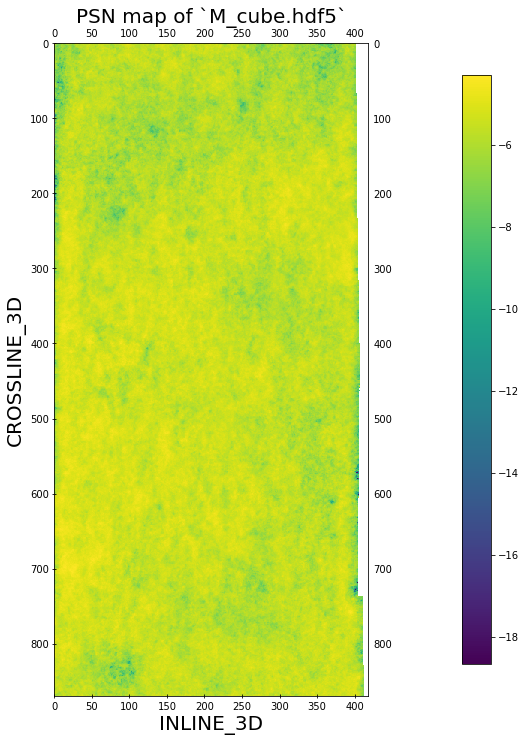

In [26]:
geometry.show_snr(figsize=(24, 12), cmap='viridis')

Obviously, all of the previous visualization functions are still available.

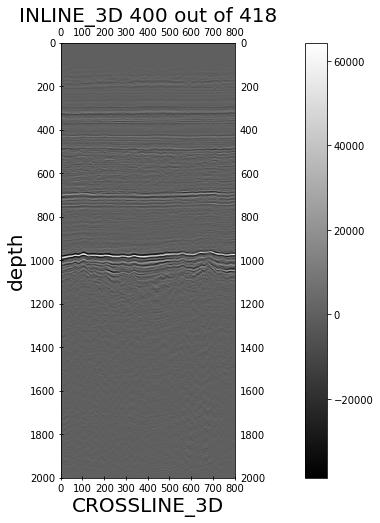

In [27]:
geometry.show_slide(loc=400, figsize=(18, 8))

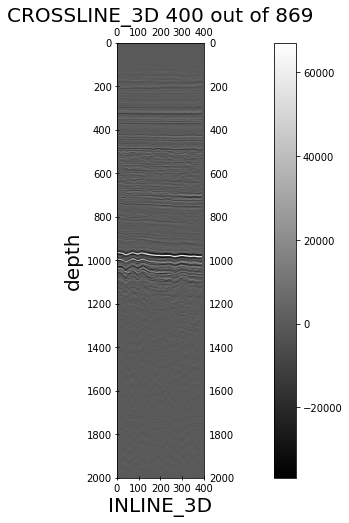

In [28]:
geometry.show_slide(loc=400, axis=1, figsize=(18, 8))

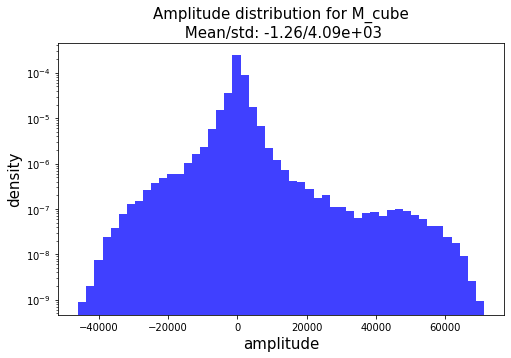

In [29]:
geometry.show_amplitude_hist(log=True)

This concludes the `SeismicGeometry` tutorial: now you know how to work with various cubes with the help of our framework. Specifically, you have learned how to:

- infer different information about 2D seismic, pre-stack and post-stack cubes
- load actual slices of data, as well as visualize them
- convert cubes with rigorous spatial structure into much faster **HDF5** format
- display simple amplitude distribution statistics

The [next tutorial](./01_Horizon.ipynb) shows how to add labeled surfaces, also knows as horizons, to the cubes!